# **Part 1: Research Question**

###A1. Provide one research question to answer using a Neural Network
Can a neural network correctly identify the species of a plant seedling from an image to reduce manual review for botanists?

###A2. Define Goals & Objectives  
The goal of this project is to create a neural network that can classify 12 types of plant seedlings based upon image data. I aim to develop a model and optimize its performance using data augmentation and normalization to enhance The model's performance and generalization. I will validate the model by tuning performance metrics such as accuracy and a confusion matrix to ensure it can distinguish between the variety of species presented. Finally, I aim to demonstrate that the model can be applied in a real-world scenario to support effective decision-making in botanical research or agriculture.

###A3+4. Identify Neural Network type & Justify Approach
This project will use a Convolutional Neural Network (CNN). This type of network is specalized for images, and can automatically detect many features specific to image datasets. This network has been employed in a variety of Similar fields such as facial recognition and medical imaging. Additionally, the layered structure and ability to capture spatial hierarchies allow it to work with moderately sized datasets - which is what the 4750 image dataset can be classified as. CNN is a well-established architecture that is efficient and accurate for image classification tasks.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Part 2: Importing & Preprocessing**



In [ ]:
# Packages and Libraries
import pandas as pd # Calculations
import numpy as np # Dataframes
import matplotlib.pyplot as plt # Visualization
import seaborn as sns # Visualization
import warnings # Squelch warnings
warnings.filterwarnings("ignore") # Squelch warnings

import tensorflow as tf # Neural Network
from tensorflow.keras.callbacks import EarlyStopping # Early Stopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Augmentation + Normalization
from tensorflow.keras.utils import to_categorical # For one-hot encoding
from tensorflow.keras.models import Sequential # Sequential Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # Layers
import json # For saving CNN History
from tensorflow.keras.models import load_model # For loading model

from sklearn.model_selection import train_test_split # Splitting Dataset
from sklearn.preprocessing import LabelEncoder # Coverts labels into categorical variables
from sklearn.metrics import confusion_matrix # Confusion Matrix
from sklearn.utils.class_weight import compute_class_weight # Class Weight


In [ ]:
# Importing the Dataset
images = np.load("/content/drive/MyDrive/Colab_Notebooks/images.npy")
labels = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/labels.csv")

In [ ]:
# Initial Profiling
print("Value Counts: ", "\n\n", labels.value_counts())
print("\nShapes:",  "\n Image shape:", images.shape)
print(" Label shape:", labels.shape)
print("\nData Types:\n", "Images Data Types:", images.dtype)
print(" Labels Data Types:", labels["Label"].dtype)

Value Counts:  

 Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
Name: count, dtype: int64

Shapes: 
 Image shape: (4750, 128, 128, 3)
 Label shape: (4750, 1)

Data Types:
 Images Data Types: uint8
 Labels Data Types: object


### B1a. Visualization of Classes

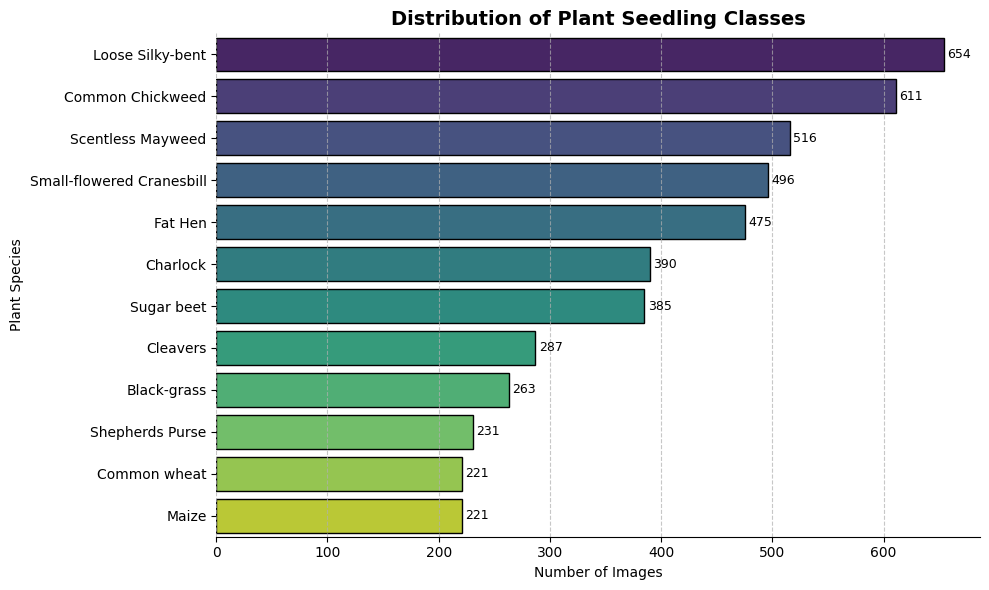

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    y='Label',
    data=labels,
    order=labels['Label'].value_counts().index,
    palette='viridis',
    edgecolor='black'
)

plt.title("Distribution of Plant Seedling Classes", fontsize=14, weight='bold')
plt.xlabel("Number of Images")
plt.ylabel("Plant Species")


for p in ax.patches: ## Add count labels on bars
    count = int(p.get_width())
    y = p.get_y() + p.get_height() / 2
    ax.text(count + 3, y, f'{count}', va='center', fontsize=9)

sns.despine(left=True)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### B1b. Visualization of Images & Labels

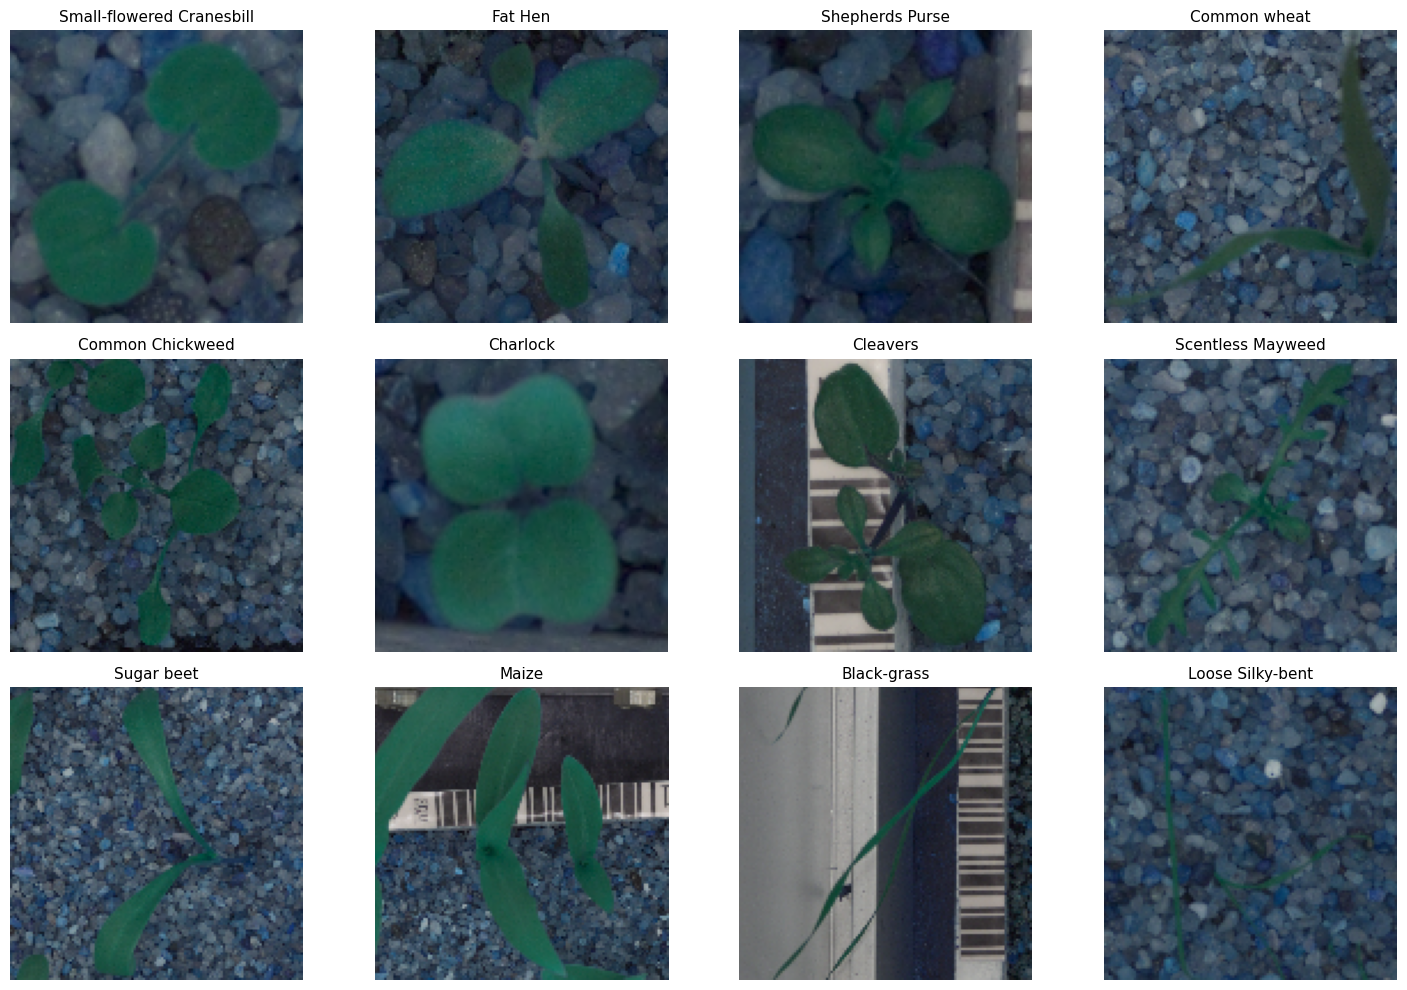

In [ ]:
# Visualizing Random Sample of all Species + Labels
plant_species = labels['Label'].unique()
plt.figure(figsize=(15, 10))

for i, plant_species in enumerate(plant_species):
    plant_indices = labels[labels['Label'] == plant_species].index
    random_index = np.random.choice(plant_indices)

    plt.subplot(3, 4, i + 1)
    plt.imshow(images[random_index])
    plt.title(plant_species, fontsize=11)
    plt.axis("off")

plt.tight_layout()
plt.show()

### B2. Data Augmentation & Justification  
Data augmentation will be performed on the training dataset to enhance the model's generalization ability and reduce overfitting. Rotation, shifting, flipping, zooming, and shearing simulate different positions and details on the images in the real world. The fill mode selected was nearest as it keeps the augmented images looking natural, and ensures the edges won't show obvious borders. This will ensure the various pictures are generalized to multiple positions as a part of the model's learning process.

In [ ]:
# Creating augment variable for training the model
augment = ImageDataGenerator(
    fill_mode='nearest',
    rotation_range=45,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    width_shift_range=0.3,
    height_shift_range=0.3
)

### B3. Normalize Images
Image normalization was applied to scale pixel intensity values from their original range of 0–255 to a normalized range of 0–1. This ensures that all image inputs have a consistent scale, which helps the neural network train more efficiently and prevents issues caused by large input values.

The steps taken to normalize were straight forward - it was a one line code item listed below that converted all pixels to a float, and divided every pixel value by 255 to change the range from `[0, 255]` to `[0, 1]`.

In [ ]:
# Normalizing the Images Dataset
images = images.astype("float32") / 255.0

### B4. Training / Validation / Testing Split & Justification
The dataset will be split into the following groups:
*   70% Training
*   15% Validation
*   15% Testing

This configuration was selected given that the dataset has 4750 values - small to medium in size. Allocating 70% to training gives the model enough examples to learn key patterns in the data. The 15% validation set allows for tuning model settings without risking adding bias to the model. The final 15% is reserved for testing, so we can see how the model performs on completely unseen data and get a realistic idea of how it might do in the real world.

### B5. Encoding Labels & Justification
Before splitting the dataset, the label values need to be encoded so the neural network can understand them. First, the labels are converted into integers using label encoding. Then, they are transformed into one-hot encoded vectors. This step prevents the model from mistakenly thinking that the classes have an order or magnitude—like “class 2” being somehow greater than “class 1.” One-hot encoding ensures that each class is treated equally, which is important for multi-class classification tasks like this.

In [ ]:
# Encoding Labels & One-Hot Encoding
le = LabelEncoder()
labels_encoded = le.fit_transform(labels['Label'])
labels_categorical = to_categorical(labels_encoded)

print("Encoded label example:", labels_encoded[0])
print("One-hot shape:", labels_categorical.shape)


Encoded label example: 10
One-hot shape: (4750, 12)


In [ ]:
# Test / Validation / Training Split

## Tempporary & Test Split
X_temp, X_test, y_temp, y_test = train_test_split(
    images, labels_categorical, test_size=0.15, stratify=labels_encoded, random_state=42
)

## Training & Validation Split
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, stratify=np.argmax(y_temp, axis=1), random_state=42
)

print("Training set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)

# Confirming all class indexes appear in the test set
print("Class indexes in y_test:", np.unique(np.argmax(y_test, axis=1)))

Training set: (3324, 128, 128, 3)
Validation set: (713, 128, 128, 3)
Test set: (713, 128, 128, 3)
Class indexes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11]


### 6. Export Copies of Datasets

In [ ]:
'''
# Exporting Datasets
save_path = "/content/drive/MyDrive/Colab_Notebooks/"

np.save(save_path + "X_train.npy", X_train)
np.save(save_path + "y_train.npy", y_train)
np.save(save_path + "X_val.npy", X_val)
np.save(save_path + "y_val.npy", y_val)
np.save(save_path + "X_test.npy", X_test)
np.save(save_path + "y_test.npy", y_test)
'''

'\n# Exporting Datasets\nsave_path = "/content/drive/MyDrive/Colab_Notebooks/"\n\nnp.save(save_path + "X_train.npy", X_train)\nnp.save(save_path + "y_train.npy", y_train)\nnp.save(save_path + "X_val.npy", X_val)\nnp.save(save_path + "y_val.npy", y_val)\nnp.save(save_path + "X_test.npy", X_test)\nnp.save(save_path + "y_test.npy", y_test)\n'

# **Part 3: Network Architecture**  



In [ ]:
# Define the CNN model architecture
model = Sequential([
  Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
  MaxPooling2D(pool_size=(2, 2)),
  Conv2D(64, (3, 3), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Conv2D(128, (3, 3), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Flatten(),
  Dense(128, activation='relu'),
  Dropout(0.5),
  Dense(12, activation='softmax')
])

### E1. Output of Model Summary

In [ ]:
# Compile the model & Output Summary
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,188 (12.61 MB)

 Trainable params: 3,306,188 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

### E2. Components and Justification of Network Structure  

The Convolutional Neural Network has 3 convolutional layers, 3 pooling layers, 1 flattening layer, 1 dropout layer and 2 dense layers for 10 layers total.

The three convolutional layers have 32, 64, and 128 filters respectively. This filter progression is typical for CNN and follows the process of taking an increasingly granular look at the data through each layer. The first layer starts with a more broad view with 32 different types of basic features, then doubles the amount of filters for each layer. This increases the model's ability to discern complex or subtle patterns necessary for differentiating 12 different types of seedlings. Three layers with this filter configuration balance the model between capacity and efficiency.

Following each convolutional layer are max-pooling layers that reduce spatial dimensions and facilitate the network by focusing on the most prominent features. This ensures the model keeps the features with the highest activations and helps the model recognize patterns even if they move slightly. Additionally, it serves to prevent overfitting by reducing parameters and layer size.

Also applied is a flattening layer, which converts a multi-dimensional tensor into a 1D vector to prepare it to be fed into a dense layer, as dense layers cannot handle 3D images such as those found in the base dataset.

A dropout layer with a 0.5 (50%) rate is implemented to set half of the input values to zero per batch/pass. This prevents overfitting by ensuring the network does not become overly dependent on a single neuron. 0.5 is a common choice which is aggressive but also effective.

A fully connected dense layer with 128 nodes is added which takes the flattened vector and processes it. This layer utilized the ReLU activation function which was also used in the convolutional layers ReLU is utilized for its efficiency and effectiveness in learning complex patterns. Specifically, it outputs the actual input if it is positive, and otherwise gives zero. This lets the network learn complex features without saturating or using too much computational power.

Finally, a dense layer with 12 nodes is added using the Softmax activation function because the final output layer is used for multi-class classification. The 12 nodes align with the different seedling types, and the Softmax activation function is ideal for identifying the likelihood that the model applies to the input belonging to each class.

Per the model's output in the code above, 3,306,188 parameters are calculated in the model. This is a fairly standard value for the number of parameters in a CNN model and a reasonable amount for a dataset of this size (4750 records).

### E3. Backpropagation & Justification of Hyperparameters

**Backpropagation Process**  
Backpropagation is the cornerstone of training neural networks. In the CNN model I created, it works by performing a forward pass, then a loss calculation, then a backward pass, and finally weight updates. More specifically, the model will use the dataset to pass input images through the layers and make a prediction, then evaluate the difference between the prediction and the true one-hot encoded labels through `categorical_crossentropy.` It then takes the loss and backpropagates it through the network via the chain rule, which calculates the gradient of the loss with respect to each weight. Finally, it uses the `Adam` optimizer to adjust the weights and minimize the loss. This process is repeated over several epochs until the model either meets the stopping criteria or runs its full course.  

**E3a. Loss Function**  
Since the task involves multi-class classification of 12 plant species, `categorical_crossentropy` is the loss function selected. Categorical crossentropy quantifies the difference between the predicted probability distribution and the one-hot encoded class labels, then penalizes the model for assigning a low probability to the correct class. This process helps the model adjust effectively. These details are why why cross-entropy loss is widely used for classification tasks (Shah, 2023).

**E3b + E3c. Optimizer + Learning Rate**  
`Adam` (Adaptive Moment Estimation) was used for this network. Amongst its strengths, `Adam` combines two optimization techniques - momentum and RMSProp (Root Mean Squared Propagation). In more lay terms, this means it remembers the general direction the gradients are going and smooths out gradient descent (momentum), and also scales the learning rate for each weight by maintaining a running average of squared gradients (RMSProp). In each step, it determines how the loss changed and which weights were responsible and adjusts them based on past updates and the reliability of the gradient. With regards to the learning rate, 0.001 is the standard learning rate for Adam. Broadly speaking, it is a safe, stable default for `Adam` across various problems and architectures. Additionally, since `Adam` adaps the learning rate for each weight internally, there is no need for a very large or small learning rate.

**E3d. Stopping Criteria**  
The model will include both a fixed number of epochs as well as a patience score. The fixed number of epochs will ensure periodic evaluation using the validation set to choose the best model version. Concurrently, a patience score will be implemented to minimize over-fitting by stopping the model when there has not been statistically significant improvement for several epochs. Implementing both of these will ensure the best model is selected at the end of the training session.

In [ ]:

# Training the Model and Implementing Stopping Criteria
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) ## Defining patience

cnn_history = model.fit(
    augment.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=25,
    callbacks=[early_stop]
)


Epoch 1/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - accuracy: 0.1205 - loss: 2.4691 - val_accuracy: 0.1585 - val_loss: 2.3964
Epoch 2/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.1487 - loss: 2.3976 - val_accuracy: 0.2917 - val_loss: 2.0826
Epoch 3/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.2626 - loss: 2.1308 - val_accuracy: 0.3422 - val_loss: 1.9223
Epoch 4/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - accuracy: 0.2845 - loss: 1.9756 - val_accuracy: 0.3604 - val_loss: 1.7665
Epoch 5/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - accuracy: 0.3014 - loss: 1.9125 - val_accuracy: 0.3997 - val_loss: 1.7855
Epoch 6/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 0.3168 - loss: 1.8616 - val_accuracy: 0.3983 - val_loss: 1.7450
Epoch 7/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.3613 - loss: 1.8030 - val_accuracy: 0.4474 - val_loss: 1.6030
Epoch 8/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.3895 - loss: 1

In [ ]:
'''
# Saving Model
model.save('/content/drive/MyDrive/Colab_Notebooks/Trained_Model.keras')

# Saving History
with open('/content/drive/MyDrive/Colab_Notebooks/training_history.json', 'w') as f:
    json.dump(cnn_history.history, f)
'''

"\n# Saving Model\nmodel.save('/content/drive/MyDrive/Colab_Notebooks/Trained_Model.keras')\n\n# Saving History\nwith open('/content/drive/MyDrive/Colab_Notebooks/training_history.json', 'w') as f:\n    json.dump(cnn_history.history, f)\n"

The below code was implemented to avoid having to re-run the entire model & identify new results every time the runtime was disconnected. This ensures continuity in analysis and avoids random initialization and data shuffling every time the model is run.

For ease of use, the coding below this cell uses the history artifacts for analysis. These should remain valid as they will be saved based on the final run of the model.

In [ ]:
# Loading Model + History
model = load_model('/content/drive/MyDrive/Colab_Notebooks/Trained_Model.keras')
with open('/content/drive/MyDrive/Colab_Notebooks/training_history.json', 'r') as f:
    history_data = json.load(f)

# Wrap history in a simple class for compatibility with your plotting code
class DummyHistory:
    def __init__(self, history_dict):
        self.history = history_dict
        self.epoch = list(range(1, len(history_dict['loss']) + 1))

cnn_history = DummyHistory(history_data)

### E4. Confusion Matrix
The purpose of a confusion matrix is to break down the performance of a classification model by comparing the true labels to the predicted labels. It presents a visualization that demonstrates how many instances of each species were correctly predicted (diagonal elements) and which species were more likely to be confused with one another (orthogonal elements). Generally speaking, it provides insights into how the model could be better refined.

In [ ]:
# Generating Confusion Matrix
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1) ## Converting one-hot encoded labels back to integers
cm = confusion_matrix(y_true, y_pred)

cm

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


array([[10,  0,  0,  1,  4,  1, 23,  0,  0,  0,  1,  0],
       [ 0, 53,  1,  0,  0,  0,  0,  1,  2,  0,  1,  1],
       [ 0,  6, 32,  0,  0,  0,  0,  0,  5,  0,  0,  0],
       [ 0,  0,  0, 84,  0,  0,  1,  0,  1,  0,  6,  0],
       [ 0,  0,  0,  0, 30,  2,  0,  0,  1,  0,  0,  0],
       [ 0,  7,  4,  1,  0, 33,  3,  2, 11,  0,  0, 10],
       [11,  0,  0,  0,  0,  2, 84,  0,  0,  0,  1,  0],
       [ 0,  1,  0,  0,  0,  0,  0, 30,  1,  0,  0,  1],
       [ 0,  6,  0,  0,  0,  1,  0,  0, 64,  4,  2,  0],
       [ 0,  3,  0,  6,  0,  2,  0,  0, 14,  8,  2,  0],
       [ 0,  0,  0,  5,  0,  0,  1,  0,  7,  0, 60,  1],
       [ 0,  2,  0,  0,  0,  1,  0,  3,  6,  0,  0, 46]])

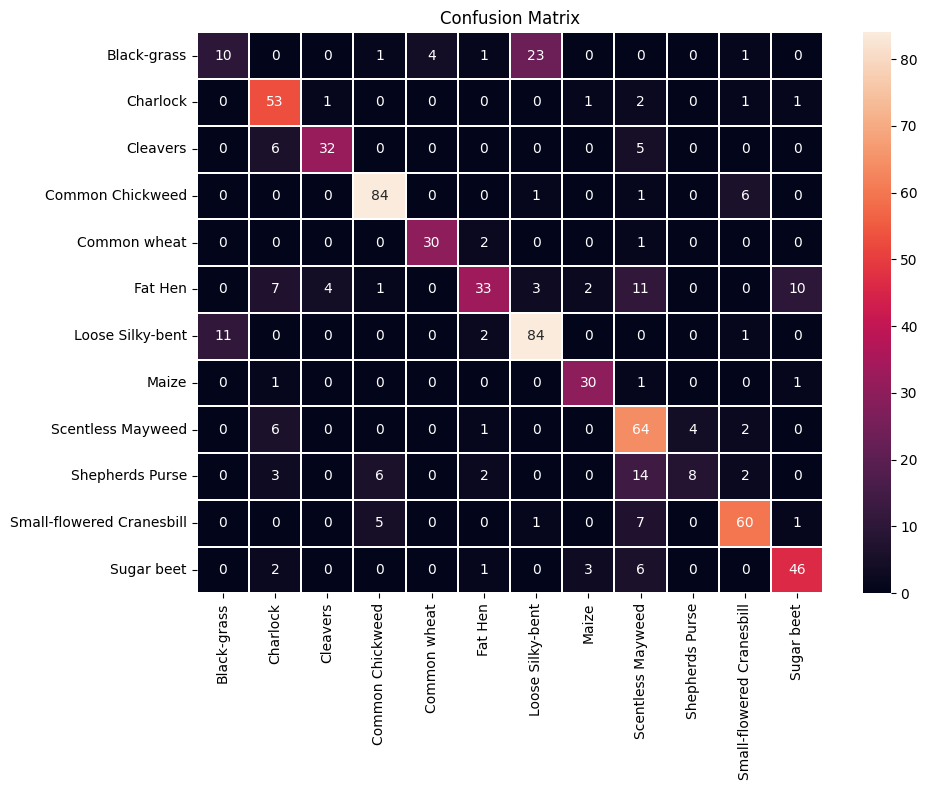

In [ ]:
# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(10, 8))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, linewidths=0.1, linecolor='white')
plt.tight_layout()
plt.show()

The confusion matrix indicates that the model is effectively predicting 10 out of the 12 plant types. Both Black-grass and Shepherd's Purse have 10 or fewer correct predictions, while most other seedling types have 30 or more.

It’s worth noting that Black-grass and Shepherd's Purse also appear less frequently in the confusion matrix overall, which suggests they may have been underrepresented in the dataset due to the random sampling process.

On the other hand, Loose Silky-bent may be overrepresented, as it has a high number of correct predictions and is the only class with more than 20 misclassifications involving a single other class — specifically, 23 Black-grass predictions were confused for Loose Silky-bent.

Overall, the confusion matrix demonstrates that the model performed well on most seedling types. With exposure to more balanced or expanded training data, especially for underrepresented classes, the model’s predictive accuracy could likely improve further.

# **Part 4: Model Evaluation**

### F1. Evaluation of Training Process & Outcomes  


**F1a. Impact of Stopping Criteria**  
I used two stopping criteria for this model - a finite amount of Epochs (25) and an early stopping condition. The early stopping callback was included to monitor validation loss and halt training if the model stopped improving. In this case, the model ran all 25 epochs, meaning the validation process improved with each iteration such that early stopping was not triggered. This suggests the model was still learning. For confirmation, the Training vs Validation loss line graph below demonstrates all 25 epochs are plotted.

**F1b. Comparing Training Data to Validation Dataset**  
The model's training accuracy was 62.2%, while it's validation accuracy was 64.1%. This slight increase in validation accuracy is not unusual and suggests the model generalized well to unseen data. There is no evidence of overfitting based on these results.

In [ ]:
# Demonstrating Training Accuracy Metric
print("Final Training Accuracy:", cnn_history.history['accuracy'][-1])
print("Final Validation Accuracy:", cnn_history.history['val_accuracy'][-1])

Final Training Accuracy: 0.6224428415298462
Final Validation Accuracy: 0.6409537196159363


**F1c: Plotting Training vs Validation Loss**

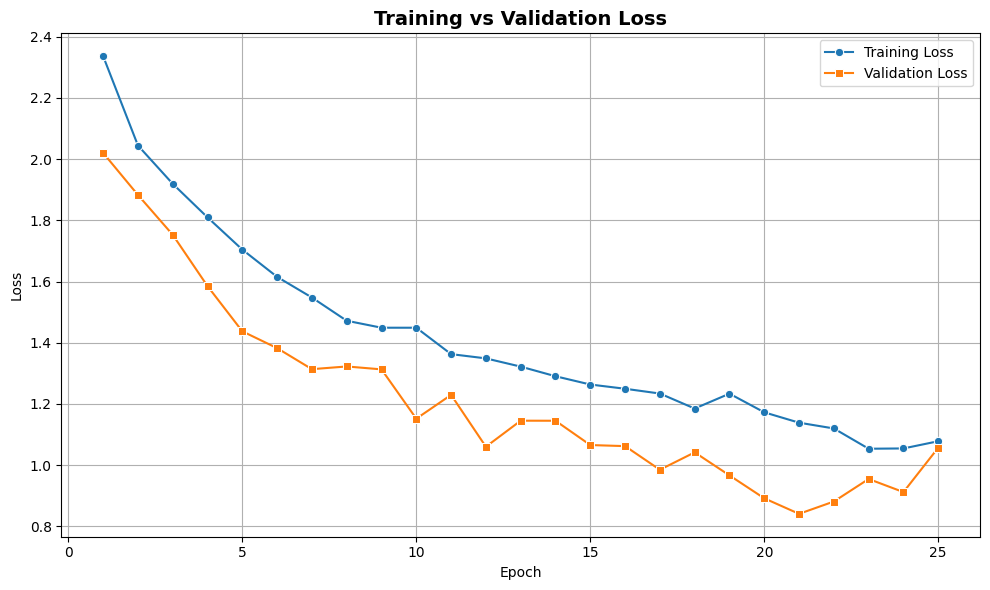

In [ ]:
# Plotting Training vs Validation Loss
plt.figure(figsize=(10, 6))
sns.lineplot(x=cnn_history.epoch, y=cnn_history.history['loss'], label='Training Loss', marker="o")
sns.lineplot(x=cnn_history.epoch, y=cnn_history.history['val_loss'], label='Validation Loss', marker="s")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss', fontsize=14, fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()


### F2. Evaluation of Model Fitness  
The Training vs. Validation Loss chart above demonstrates that the model fits the data soundly. Both the training and validation sets steadily decelerated throughout the first 20 training epochs, indicating no signs of underfitting. At around epoch 21, the validation loss dataset started an accelerating trend; at around epoch 23, the training loss dataset started a flat or slightly accelerating trend. The divergence remained small until around epoch 25 when both datasets converged and met with nearly matching values. This indicates epoch 25 provided a balanced stopping point where the model could generalize well to unseen data.

### F3. Predictive Power of the Network for Training vs. Test Sets  
The trained model was evaluated on the test set and achieved an accuracy of approximately 74.9%. This is an improvement in the training accuracy of 62.2%. This suggests the model generalized well and did not overfit the training data. The consistent performance of accuracy across the datasets indicates the CNN learned meaningful patterns and is likely to make predictions with a high degree of reliability on new data.

In [ ]:
# Printing Test vs Training Accuracy
_, test_accuracy = model.evaluate(X_test, y_test, verbose='0')
print("Test Accuracy:", test_accuracy)
print("Training Accuracy:", cnn_history.history['accuracy'][-1])


Test Accuracy: 0.7489480972290039
Training Accuracy: 0.6224428415298462


# **Part 5: Summary and Recommendations**  
### G1: Code to Save the Trained Network
```
# Saving Model
model.save('/content/drive/MyDrive/Colab_Notebooks/Trained_Model.keras')

# Saving History
with open('/content/drive/MyDrive/Colab_Notebooks/training_history.json', 'w') as f:
    json.dump(cnn_history.history, f)
```

The above code blocks saved the model to a `keras` file to be easily reaccessed for validation and testing. The training history was also saved in a format I could reload later for plots and analysis.

### G2: Functionality of Neural Network & Impact of Network Architecture  

With 75% predictive accuracy on the test set, a steadily decreasing trend in training vs. validation for each epoch, and a confusion matrix that demonstrated consistent predictions for 10 out of the 12 seedling classes, the network performed effectively overall.

The architecture of the model was successfully implemented using a convolutional neural network with multiple layers that contributed to its strong performance. The architecture included three Conv2D layers, each followed by a max pooling layer. The Conv2D layers enabled effective feature extraction and pattern recognition, and the max pooling layers reduced computational complexity while retaining the relevant features, and also prevented overfitting. The flattening layer converted a multi-dimensional tensor into a 1D vector to prepare it to be fed into a dense layer. The dropout layer set half of the values each pass to zero to prevent overfitting and reduce the likelihood that the network became overly-dependent on a single neuron.

The fully connected dense layer with 128 nodes utilized a RelU activation function to take the flattened vector and process it. Finally, a dense layer with 12 nodes and a softmax activation function served as the output layer to appropriately classify the seedlings into their respective types.



### G3: Effectiveness of Model for Business Question  
The research question, "*Can a neural network correctly identify the species of a plant seedling from an image to reduce manual review for botanists?*" was effectively addressed by the model, which achieved 75% accuracy on the test dataset after 25 training epochs. The steadily improving performance across epochs, combined with no evidence of overfitting or underfitting, indicates that the model was well-trained and generalized effectively.

From a business perspective, this model could be valuable in automating plant species identification in agriculture, seed sorting, or botanical research. By correctly classifying 10 out of 12 seedling types with strong consistency, the model shows the potential to reduce human error and eliminate the need for manual identification to improve efficiency and accuracy. It could be implemented in real-world scenarios with further refinement and more balanced training data.

### G4: Lessons Learned & Model Improvement  
The model could be improved through several common strategies. First, the dataset could be balanced more effectively to prevent it from favoring overrepresented classes or struggling with underrepresented ones. Hyperparameters such as the learning rate or dropout percentage could be tuned to test for more accurate results. The model could be trained with additional epochs, allowing early stopping to determine the most effective stopping point. Finally, a more advanced architecture could be implemented, such as Residual Networks or MobileNet (Baheti, 2021).

### G5: Recommended Course of Action  
Based upon the relative success of the model and its predictive power, my recommendation to the business would be to continue building upon the foundation of this model by expanding it into a more robust solution. First, feeding additional data into the network would enhance its learning capabilities, leading to improved accuracy. Increasing sample sizes reduces the problem of over or under-selecting seedling types, which resulted in worse classification for Black Grass and Shepards Purse. In the interim, each of these seedling types should be validated manually where possible to prevent inaccurate identification. Second, I recommend adjusting the dropout rate, learning rate, and training with variable epochs to improve the model's effectiveness compared to the initial implementation.


# **Part 6: Sources**  

## Acknowledgement of Code Sources  
SnaSeaborn. (n.d.) *seaborn.countplot*. https://seaborn.pydata.org/generated/seaborn.countplot.html

swiss_knight. (2019, April 29). Keras: How to save the training history attribute of the History object? [Online forum post]. Stack Overflow. https://stackoverflow.com/questions/41061457/keras-how-to-save-the-training-history-attribute-of-the-history-object

## Acknowledgement of Sources
Shah, D. (2023, January 26). Cross-entropy loss explained: A complete guide. V7 Labs. https://www.v7labs.com/blog/cross-entropy-loss-guide

Baheti, P. (2021, July 8). Neural network architectures explained: CNNs, RNNs, GANs, transformers & more. V7 Labs. https://www.v7labs.com/blog/neural-network-architectures-guide


